<font size="6"><b><i>Brian2</i> Simulation of Calcium Based Plasticity in a Spiking Model</font>

                                                                           Hanyu Li
                                                                           03/25/2016

In [1]:
from IPython.display import display, Math, Latex

# Background and Previous Work

<font size="4">Synaptic efficacy changes induced by calcium is believed to be the substrate for long term memory. 
<br>
<br>
Experiments have shown that such memory traces in IT cortex causes the neurons to fire differently in regard to "familiar" and "novel" stimuli.
<br>
<br>
Such effect has been reproduced by a rate model simulation. In this work, we are interested in reproducing that with a spiking model

## 1. Rate Model Plasticity and Change in Firing Rate Distribution 

<font size="4"><b>Rate Model and Learning Rule inference in Sukbin et.al, 2016:</b> 

<div style="align: left; text-align:center;">
<img src="pictures/sukbin2.png", height=350, width=500>
<div class="caption">Fig.1 Comparison between simulated and experimental data, (a-b). Mean, (c-d), Max 
</div>



<br>
<br>

<div style="align: left; text-align:center;">
<img src="pictures/sukbin1.png", height=350, width=500>
<div class="caption">Fig.2 Comparison between simulated and experimental data(Normalized)
</div>



\begin{equation}
\tau_E  \frac{dr_i^E}{dt} = - r_i^E + 
    \Phi_E ( \sum_{j=1}^{N_E} W_{ij}^{EE} r_j^E - \sum_{j=1}^{N_I} W_{ij}^{EI} r_j^I + I_i^{EX})
\end{equation}

\begin{equation}
\tau_I  \frac{dr_i^I}{dt} = - r_i^I + \Phi_I ( \sum_{j=1}^{N_E} W_{ij}^{IE} r_j^E + I_i^{EX})
\end{equation}

in which $\Phi$ is the f-I transfer function

Plasticity obeys 

Plasticity is described by:

\begin{equation}
\Delta W_{ij}^{EE} \leftarrow \Delta W_{ij}^{EE} - \frac{1}{N_E} \sum_{j=1}{N_E}\Delta W_{ij}^{EE}
\end{equation}




## 2. Calcium Plasticity in Spiking Model


<font size="4"><b>Calcium Based Plasticity Rule Described by Grauper-Brunel Model(Grauper et.al, 2012):</b> 

\begin{equation}
\tau \frac{d\rho}{dt} = -\rho (1-\rho)(\rho_*- \rho)
        + \gamma_p (1-\rho)\Theta[c(t)-\theta_p]
        - \gamma_d \rho \Theta[c(t)-\theta_d] + Noise(t)
\end{equation}



<div style="align: left; text-align:center;">
<img src="pictures/calcium_dynamics1.png">
<div class="caption">Fig.3 Order of Pre-Post Spike Pair causes potentiation or depression 
</div>

<br>
<br>

<b>Variation in Higgins(2014)</b>

\begin{equation}
\tau \frac{d\rho}{dt} = -\frac{\partial U(\rho)} {\partial \rho}
        - \gamma_d \rho \Theta[c(t)-\theta_d] 
        + \gamma_p (1-\rho)\Theta[c(t)-\theta_p]
        + \sigma \sqrt{\tau} \sqrt{\Theta(t)[c(t) - \theta_D] + \Theta[c(t)-\theta_P]} \eta(t)
\end{equation}

in which

$U(\rho) = \frac{1}{4} \rho^2 (1-\rho)^2, \ \eta(t)\ is\ Gaussian\ noise$
<div style="align: left; text-align:center;">
<img src="pictures/calcium_dynamics2.png", height=350, width=500>
<div class="caption">Fig.4 Pre-Post Spike Train and Synaptic Efficacy Changes 
</div>

# Introduction

<font size="5">
Aims: 
1. Simulating Calcium Plasticity in a spiking neural network using Brian
<br>
<br>
2. To reproduce the firing rate distribution observed in IT cortex
<br>
<br>
3. To reproduce the effect of learning on firing rate distribution

<font size="4">A E-I network with 4:1 ratio, probability of connection = 0.05

In [2]:
import sys
sys.path.append("../")
from d3js_network import show_network
%cd ~/pypath/calcium-spike-model/notebooks/
show_network(template='connectivity_E_200_I_50.template',
            connectivity='connectivity_E_200_I_50.json',  w=900,h=800)
#show_network(template='connectivity_E_500_I_125.template',
#            connectivity='connectivity_E_500_I_125.json',  w=900,h=900)

/home/hanyu/pypath/calcium-spike-model/notebooks


In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 99999;

<IPython.core.display.Javascript object>

# Simulation

In [4]:
from brian_utils import *
from brian_simulator import *
%matplotlib inline
%cd ~/pypath/calcium-spike-model/

/home/hanyu/pypath/calcium-spike-model


In [5]:
params = {
    'cpre_0':0.1,
    'cpost_0':0.1,
    'rho_0':0.5,
    'c':0.2,
    'dummy':0.2,
    'Ipre':0,
    'Ipost':0,
    'w0':0.5,
    'w_EE':0.2,
    'w_IE':0.1,
    'w_II':-0.4,
    'w_EI':-0.4,
    #LIF specific constants,
    'tau_lif':26, #*ms
    'V_init':-60,
    'V_rest':-70,
    'V_reset':-70,
    'V_threshold':-50,
    'CM':0.001,
    'RM':20.0,
    'refrac':0,
    #Synapse model specific constants,
    'rho_init':0.019,
    'ca_initial':0,
    'ca_delay':4.61, #ms
    'Cpre':0.56175,
    'Cpost':1.23964,
    'eta':0,
    'tau_ca':22.6936,
    'theta_D':1,
    'theta_P':1.3,
    'gamma_D':331.909,
    'gamma_P':725.085,
    'taurho':346361, #*ms
    'taurho_fast':10, #*ms # dummy,
    'taupre':22,
    'taupost':22,
    'tau_ca':22, #*ms
    'rho_star':0.5,
    'D':4.6098,
    'baseline_I_ext_E':25,
    'baseline_I_ext_I':35,
    'mean_I_ext_E':40,
    'mean_I_ext_I':50,
    'sigma':20,
    'familiar_individual_sigma':9}

<b> Initialize Brian Parameters, mostly adapted from Higgins(2014)</b>
<img src="../notebooks/pictures/params.png", height=400, width=400>

### Setup simulator

In [6]:
# additively applied to params
param_diffs = {
    'cpre_0':0,
    'cpost_0':0,
    'rho_0':0,
    'c':0,
    'dummy':0,
    'Ipre':0,
    'Ipost':0,
    'w0':0,
    'w_EE':0,
    'w_IE':0,
    'w_II':0,
    'w_EI':0,
    #LIF specific constants,
    'tau_lif':0, #*ms
    'V_init':0,
    'V_rest':0,
    'V_reset':0,
    'V_threshold':0,
    'CM':0,
    'RM':0,
    'refrac':0,
    #Synapse model specific constants,
    'rho_init':0,
    'ca_initial':0,
    'ca_delay':0, #ms
    'Cpre':0,
    'Cpost':0,
    'eta':0,
    'tau_ca':0,
    'theta_D':0,
    'theta_P':0,
    'gamma_D':0,
    'gamma_P':0,
    'taurho':0, #*ms
    'taurho_fast':0, #*ms # dummy,
    'taupre':0,
    'taupost':0,
    'tau_ca':0, #*ms
    'rho_star':0,
    'D':0,
    'baseline_I_ext_E':0,
    'baseline_I_ext_I':0,

    #'mean_I_ext_E':0,
    #'mean_I_ext_I':0,
    #'sigma': 0,
    #'familiar_individual_sigma':0}

    'mean_I_ext_E':0,
    'mean_I_ext_I':0,
    'sigma':0,
    'familiar_individual_sigma':0}
    


# Control variables
simulation_length =8000
stair_length = 500
N_E = 1000
N_I = 250
sample = 10
input_flag = '_fam_fam_nov_'
resets = 1
debug = True

sim = Brian_Simulator(simulation_length=simulation_length, stair_length=stair_length,N_E=N_E,N_I=N_I,sample=sample,
         params=params, debug=debug)





# prepare result variables
spike_dict = build_real_value_spike_dict(params,param_diffs) # store spike trains for each parameter set
param_trial_num = len(spike_dict)
binned_rate_E = np.zeros((simulation_length * 10, param_trial_num))
binned_rate_I = np.zeros((simulation_length * 10, param_trial_num))
rho = np.zeros((N_E, simulation_length, param_trial_num))
mean_rate_shift =np.zeros((param_trial_num,1))


if param_trial_num == 1:
    mode = 'cpp_standalone'
else:
    mode = 'cython'


t = arange(simulation_length)

### Run simulator for each parameter set(only 1 in this demo)

WARNING  py.warnings: /home/hanyu/anaconda2/lib/python2.7/site-packages/brian2/groups/group.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item is None or item == 'True':

  if item is None or item == 'True':



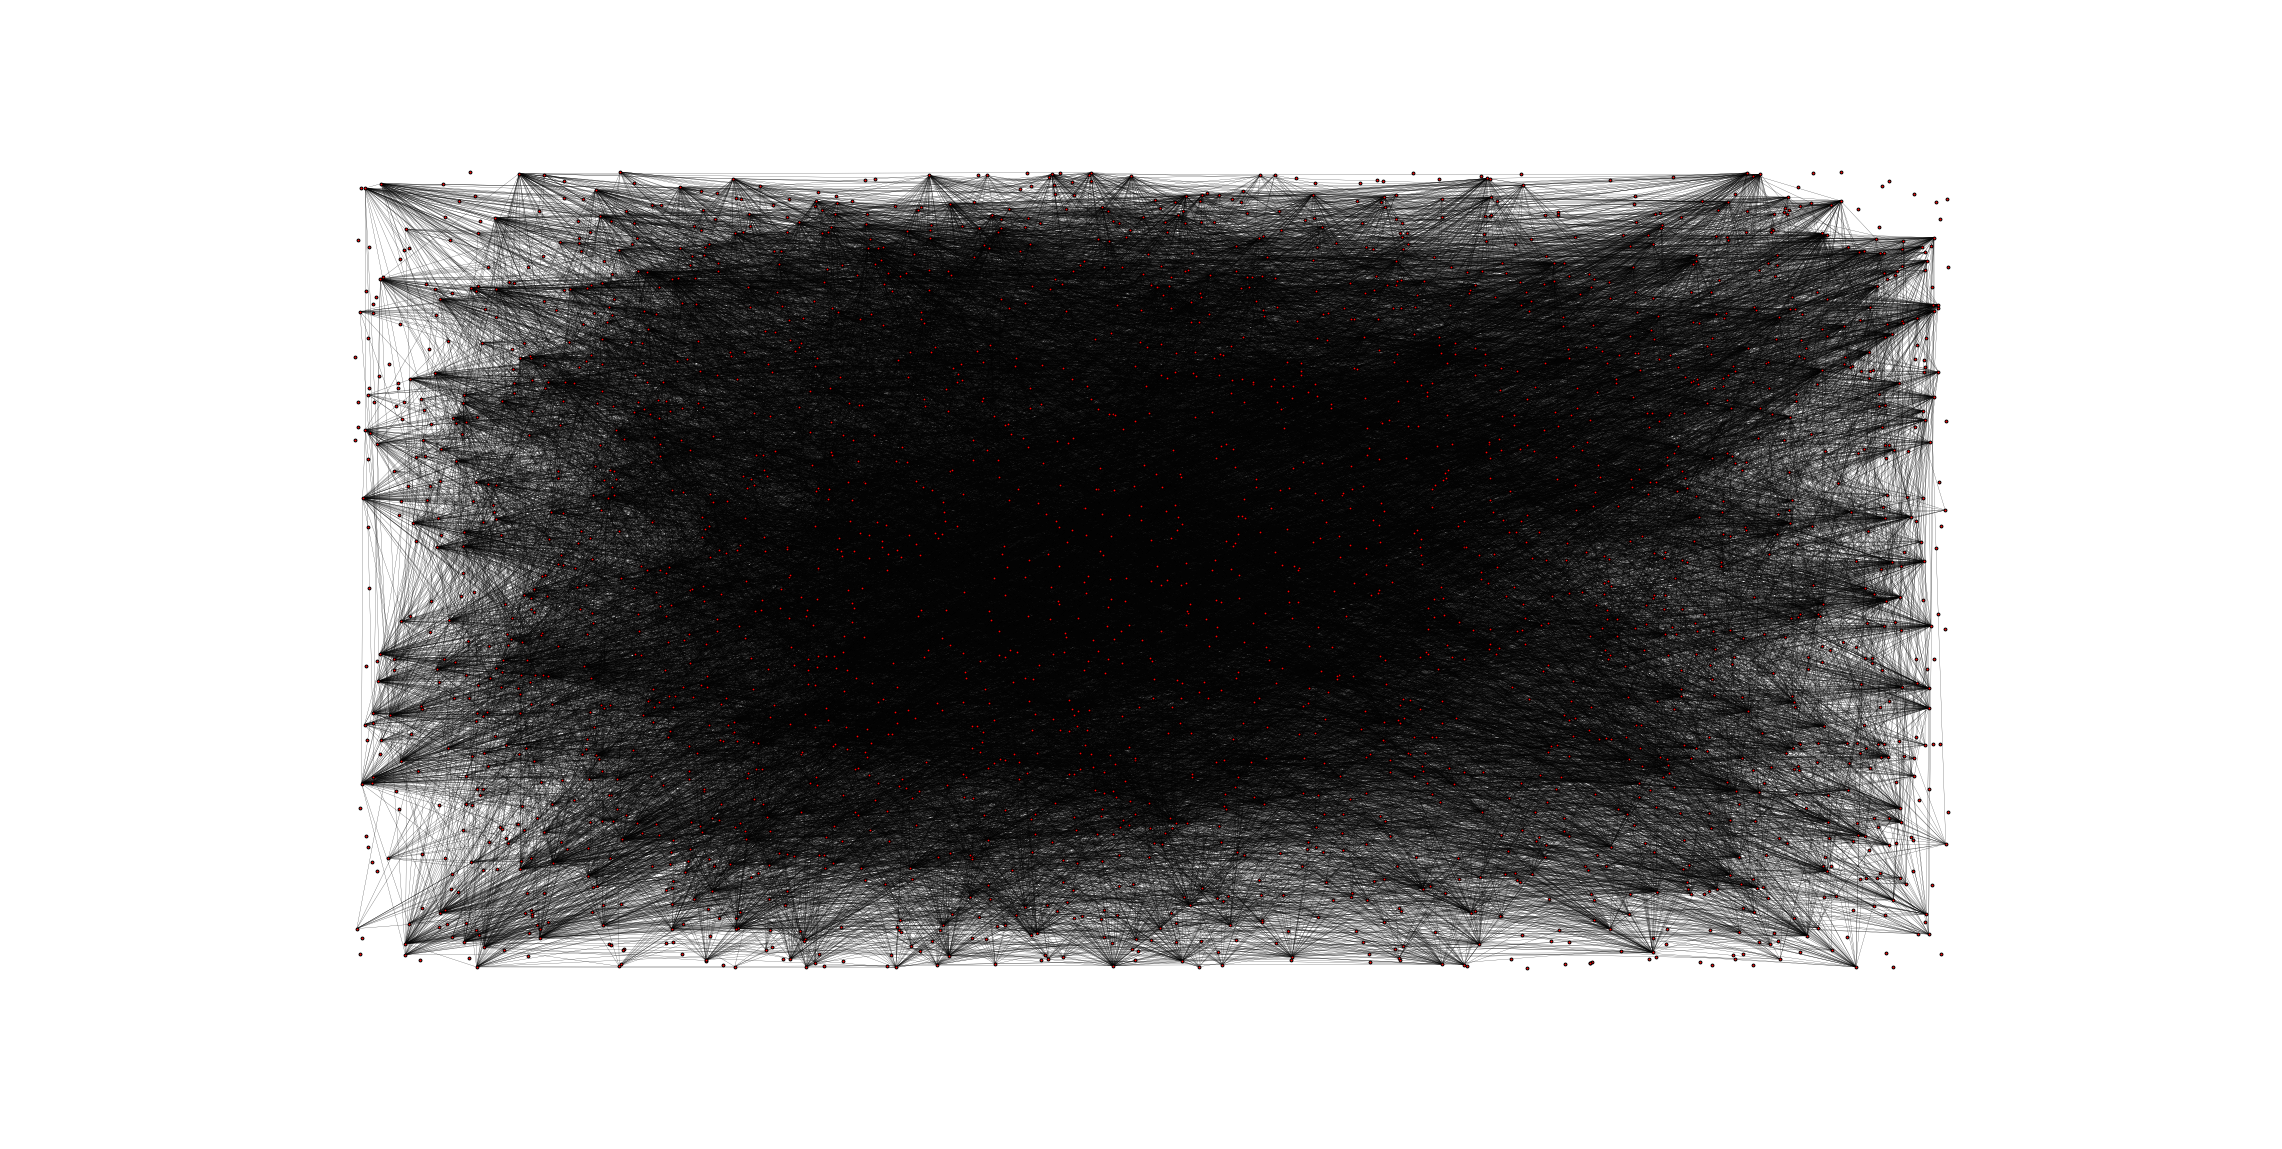

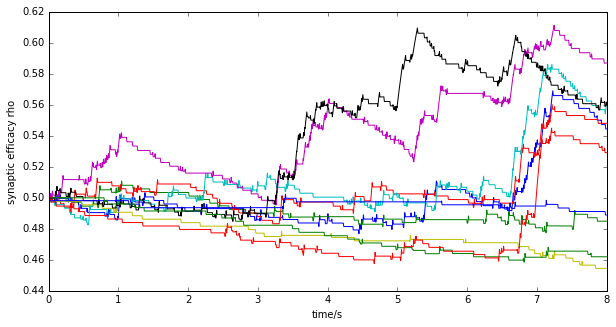

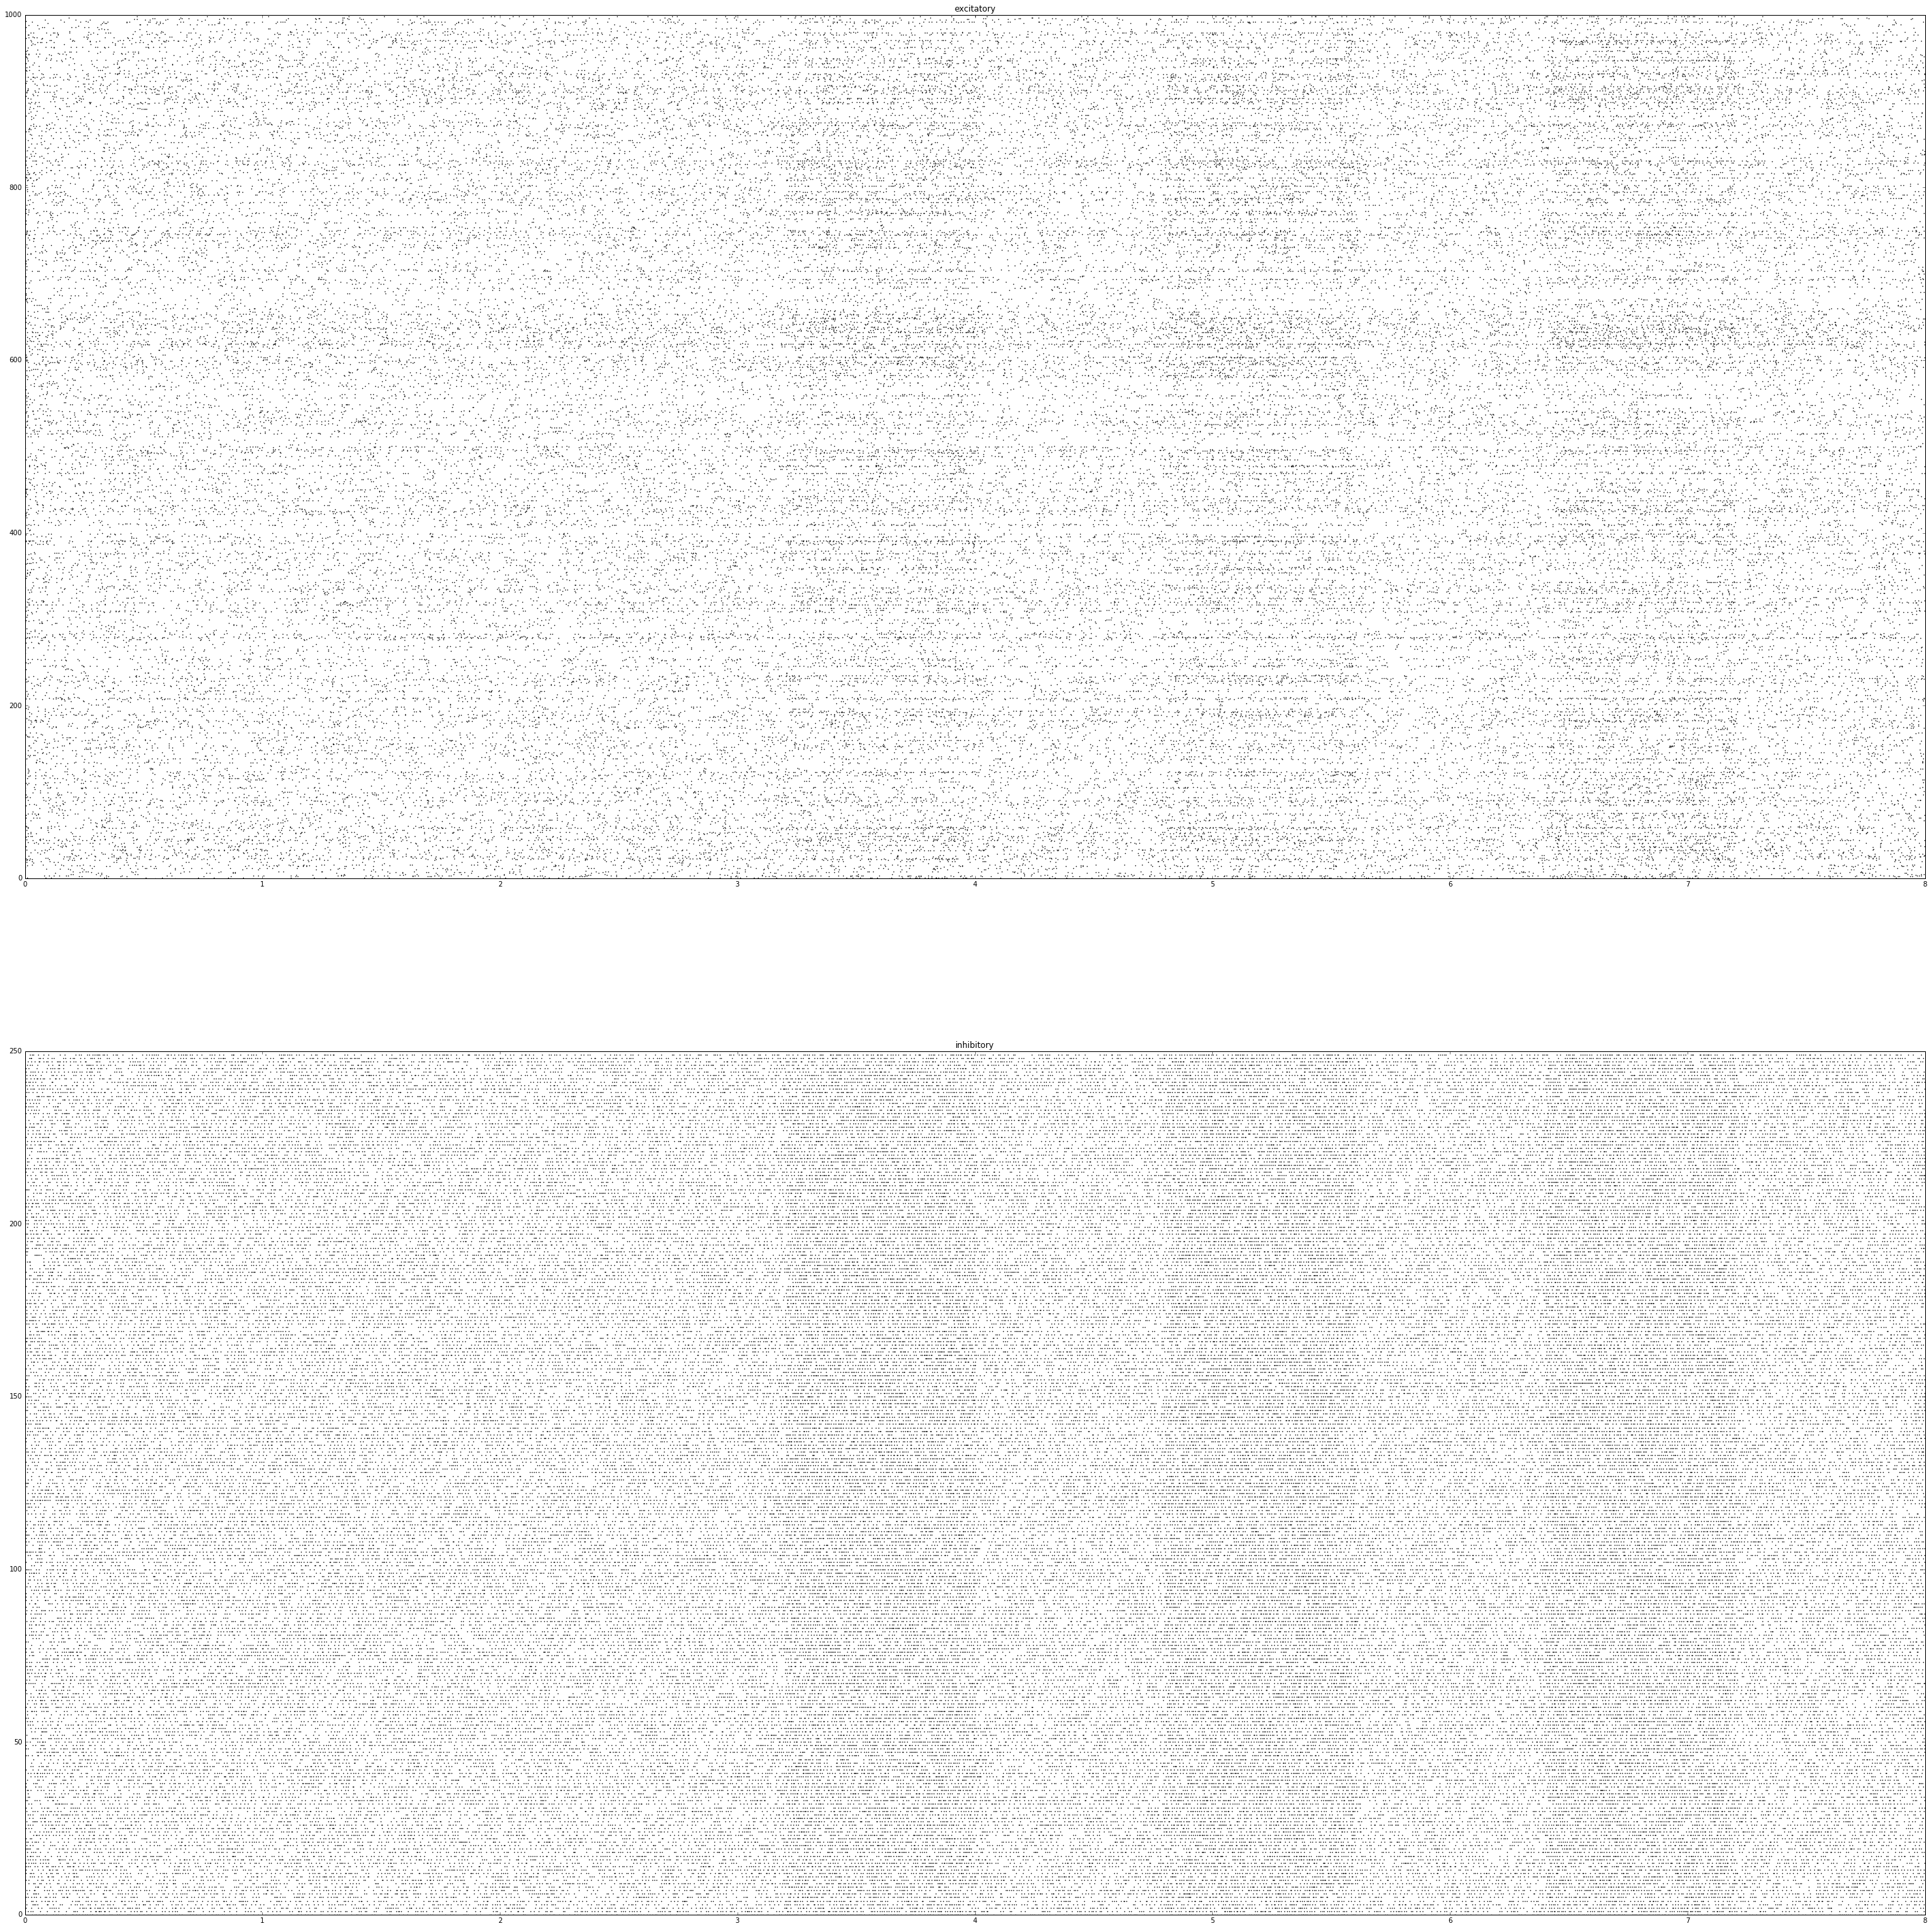

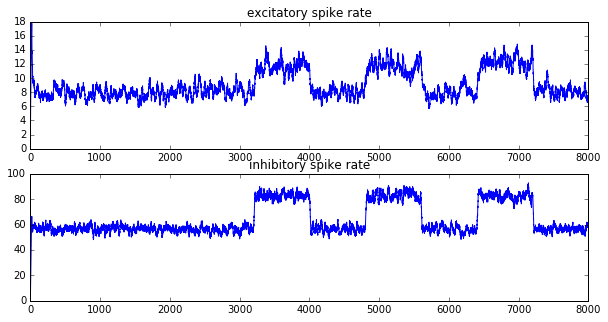

In [7]:

for ind, key in enumerate(spike_dict):
    cpp_directory = 'output_'+str(ind)
    (I_ext_E, I_ext_I, binned_rate_E[:,ind], binned_rate_I[:,ind], rho[:,:,ind], spike_dict[key]) = sim.run(key, mode=mode, input_flag=input_flag, resets=resets, cpp_directory=cpp_directory)


### Analysis

[ 3.199  0.8    0.8    0.8    0.8    0.8    0.801]
(1000, 7)


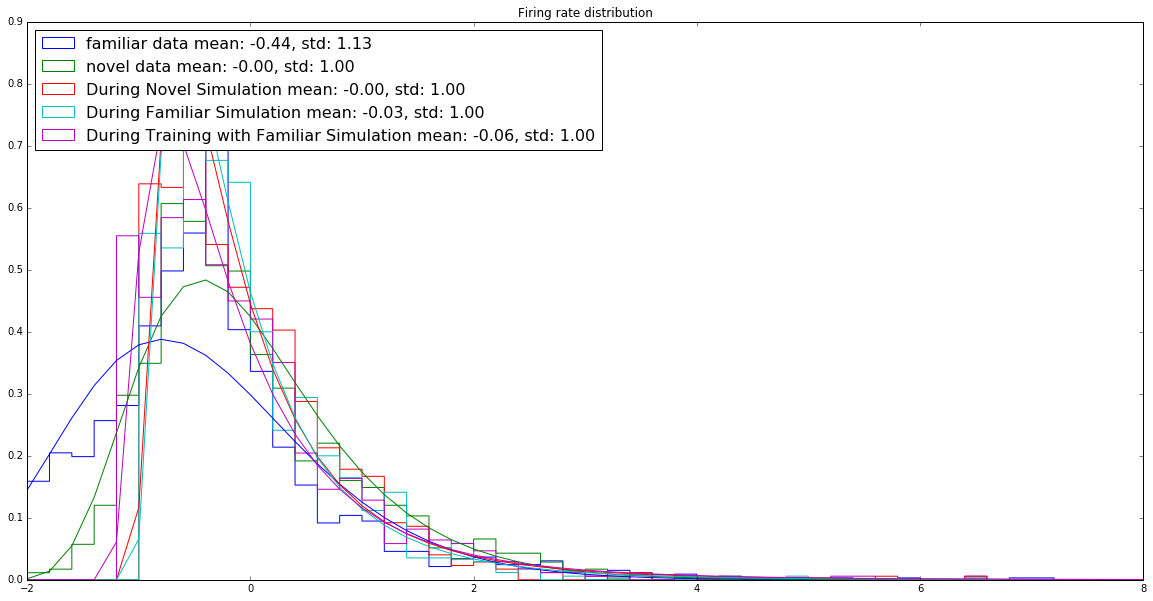

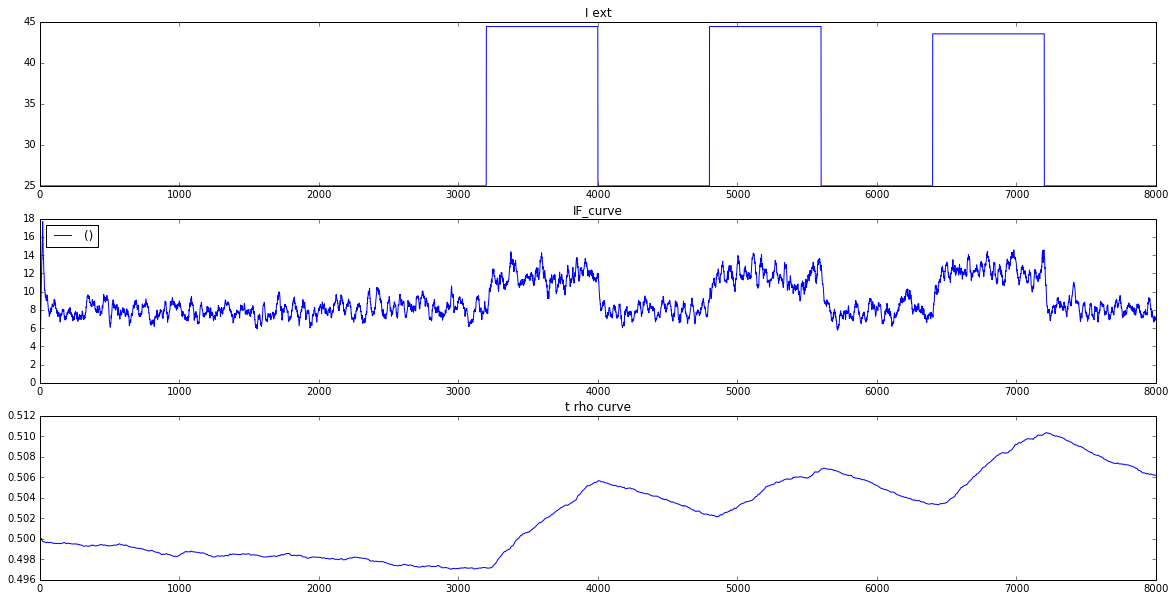

In [8]:

(R_fam_E, R_fam_I, R_nov_E, R_nov_I) = unpack_raw_data('data/Data_Sheinberg_Neuron2012_FiringRates.mat')
analyse_all_parameter_sets(t, I_ext_E, spike_dict,R_fam_E,R_nov_E, params) 
visualize_all(I_ext_E, binned_rate_E, rho, t, resets, spike_dict.keys(), input_flag)
show()

# Results

## Three fitting paradigms
<font size="4">1. Fitting single neuron with raw firing rate distribution
<font size="4">2. Fitting multiple neurons with normalized firing rate distribution
<font size="4">3. Fitting multiple neurons with raw firing rate distribution 

### 1. Fitting single neuron
<font size="4">A single neuron's firing rate follows a lognormal distribution as shown in the following figure, a novel stimulus triggers larger firing rate than a familiar stimulus
<img src="pictures/single_neuron_fitting.png", height=400, width=400>

This can be fitted closely with the spiking model
<img src="pictures/single_neuron_fitting_sim.png">

### 2. Fitting multiple neurons with normalized firing rate distribution 
<font size="4"> Because each recorded neuron has different mean and variance, the first step is to normalize their firing rate with regard to each sample's mean, and plot variance in units of std
<img src="pictures/multi_neuron_fitting.png">

This can also be fitted closely with the spiking model, by numerically closing in toward the best fitting parameters
<img src="pictures/multi_neuron_fitting_sim.png", height=1500, width=1500>
<img src="pictures/csv.png",height=900, width=900>



### 3. Fitting multiple neurons with raw firing rate distribution(Unsuccessful) 
<font size="4"> This simulation paradigm proves challenging, if not impossible, to fit with real data. 

Mostly because each recorded has individual mean and variance, when binned together, they nolonger follow lognormal distribution
<img src="pictures/raw_dist.png", height=1500, width=1500>

<img src="pictures/raw_dist_sim.png", height=1500, width=1500>

To fix this, potential options are:
1. Build an exact mapping between real neuron and simulated neuron. Adjust each neuron's weight for it to get the mean rate  
2. Using fine tuned external input to train each neuron until reaching mean rate

## Conclusion and Future Directions
<font size="4"> 
1. The spiking model can reproduce the lognormal firing distribution that closely fit a recorded neuron
<br>
<br>

2. The spiking model can also fit a normalized firing rate distribution obtained from real data
<br>
<br>
3. Due to time constraint, the plasticity rule is kept linear ($ \eta=0, C = C_{pre} + C_{post} + \eta*C_{pre}C_{post} $) and the effect of nonlinear term $\eta$ has not been further investigated, 
<br>
<br>
4. Need better way to fit the learning rule("quantify familiarity"), difference between novel and familiar stimulus is not significant enough yet. 
<br>
<br>

5. Find better simulation technique to mirror recorded data
